
# Recherche aléatoire et recuit simulé


In [1]:
using Random
using LinearAlgebra
using Plots

Ce notebook présente une méthode d'optimisation **sans gradient**, à savoir le **recuit simulé**.

Cette méthode est adaptée aux problèmes où :
- la fonction n’est pas dérivable,
- le gradient est coûteux ou indisponible,
- la fonction est considérée comme une *boîte noire* mais peu coûteuse à évaluer.

Le code est volontairement simple pour se concentrer sur les principes fondamentaux.

## Principe du recuit simulé

Le recuit simulé est une extension probabiliste de la recherche aléatoire.

À chaque itération:
- si le candidat améliore la fonction, il est accepté
- sinon, il peut être accepté avec une certaine probabilité

Cette probabilité dépend:
- de la dégradation de la fonction
- d'un paramètre appelé **température**

## Règle d’acceptation (critère de Metropolis)

Soit $\Delta f = f(x_{\text{cand}}) - f(x)$. Alors,
- si $\Delta f < 0$: le candidat est accepté;
- sinon, il est accepté avec la probabilité
$$
P = \exp\left(-\frac{\Delta f}{T}\right),
$$
où $T$ est la température. Quand $T$ est élevée, les détériorations sont souvent acceptées. Quand $T \to 0$, l'algorithme devient une descente stricte.

## Décroissance de la température

Nous utilisons une décroissance géométrique:
$$
T_{k+1} = \alpha \, T_k
$$
avec
- $T_0$ température initiale;
- $\alpha \in (0,1)$.

Ce schéma est simple et largement utilisé en pratique.

In [6]:
function simulated_annealing(f::Function, x0::Vector, nmax::Int;
    stepsize::Float64 = 1.0, T0::Float64 = 1.0, alpha::Float64 = 0.99,
    patience::Int = nmax, record::Bool = false)

    n = length(x0)
    x = copy(x0)
    value = f(x)
    T = T0
    no_improve = 0

    xs_all = record ? Vector{Vector{Float64}}() : nothing
    fs_all = record ? Float64[] : nothing
    xs_acc = record ? Vector{Vector{Float64}}() : nothing
    fs_acc = record ? Float64[] : nothing

    if record
        push!(xs_acc, copy(x))
        push!(fs_acc, value)
    end

    for k in 1:nmax
        Δx = stepsize * (2rand(n) .- 1)
        xcand = x + Δx
        cand = f(xcand)
        Δf = cand - value

        if record
            push!(xs_all, xcand)
            push!(fs_all, cand)
        end

        accept = Δf < 0 || rand() < exp(-Δf / T)

        if accept
            x = xcand
            value = cand
            no_improve = Δf < 0 ? 0 : no_improve + 1
            if record
                push!(xs_acc, copy(x))
                push!(fs_acc, value)
            end
        else
            no_improve += 1
        end

        if no_improve ≥ patience
            break
        end

        T *= alpha
    end

    return record ? (x, value, xs_all, fs_all, xs_acc, fs_acc) : (x, value)
end


simulated_annealing (generic function with 1 method)

## Exemple en dimension 2

Nous considérons la fonction quadratique
$$
f(x, y) = x^2 + y^2.
$$

In [4]:
f(x) = x[1]^2 + x[2]^2

([-0.0006437100862031198, -0.014542072466132261], 0.00021188623428532164)

In [ ]:
x0 = [3.0, -2.0]

xopt, fopt, xs_all, fs_all, xs_acc, fs_acc =
    simulated_annealing(f, x0, 5000; record=true)

xopt, fopt

## Analyse de la convergence

Traçons
- la valeur de la fonction pour tous les points testés,
- la valeur de la fonction pour les points acceptés.

Généralement, nous pouvons observer
- une forte exploration au début,
- puis une stabilisation progressive autour du minimum.

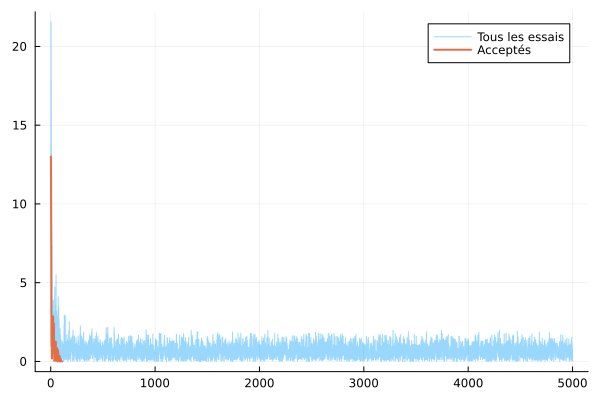

In [5]:

plot(fs_all, label="Tous les essais", alpha=0.4)
plot!(fs_acc, label="Acceptés", linewidth=2)


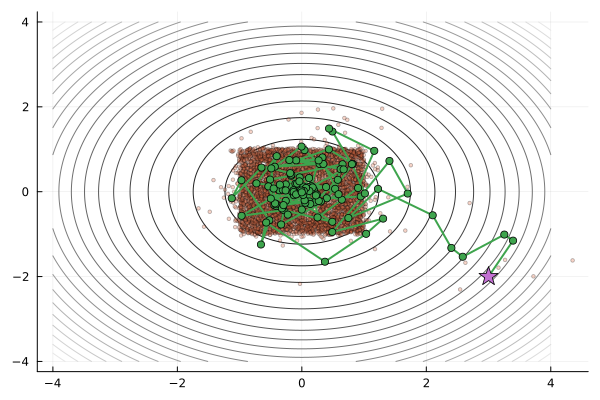

In [8]:
# Grille pour les courbes de niveau
xgrid = range(-4, 4, length=200)
ygrid = range(-4, 4, length=200)

Z = [f([x, y]) for y in ygrid, x in xgrid]

# Extraction des coordonnées des itérés
X_all = [x[1] for x in xs_all]
Y_all = [x[2] for x in xs_all]

X_acc = [x[1] for x in xs_acc]
Y_acc = [x[2] for x in xs_acc]

# Courbes de niveau
contour(
    xgrid, ygrid, Z;
    levels=20,
    linewidth=1,
    color=:grays,
    legend=false
)

# Points testés (exploration)
scatter!(
    X_all, Y_all;
    markersize=2,
    alpha=0.3,
    label="Points testés"
)

# Points acceptés (trajectoire)
plot!(
    X_acc, Y_acc;
    marker=:circle,
    markersize=4,
    linewidth=2,
    label="Itérés acceptés"
)

# Point initial
scatter!(
    [x0[1]], [x0[2]];
    marker=:star5,
    markersize=10,
    label="Point initial"
)